# <h2>Part A: Linear Classification Models

<h5>Data Preparation

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset, Subset
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))]) #flatten 28*28 to 784 features

train_data_MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data_MNIST  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_data_MNIST = ConcatDataset([train_data_MNIST, test_data_MNIST])
targets = np.concatenate((train_data_MNIST.targets.numpy(),test_data_MNIST.targets.numpy()))
indices = np.arange(len(targets))

train_idx, temp_idx, y_train, y_temp = train_test_split(indices, targets, test_size=0.4, stratify=targets, random_state=42)
val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

train_dataset = Subset(full_data_MNIST, train_idx)
val_dataset   = Subset(full_data_MNIST, val_idx)
test_dataset  = Subset(full_data_MNIST, test_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

mask = (targets == 0) | (targets == 1)
filtered_indices = indices[mask]
filtered_targets = targets[mask]
train_idx_bin, temp_idx_bin, y_train_bin, y_temp_bin = train_test_split(filtered_indices, filtered_targets,test_size=0.4, stratify=filtered_targets, random_state=42)
val_idx_bin, test_idx_bin, y_val_bin, y_test_bin = train_test_split(temp_idx_bin, y_temp_bin,test_size=0.5, stratify=y_temp_bin, random_state=42)

train_dataset_bin = Subset(full_data_MNIST, train_idx_bin)
val_dataset_bin   = Subset(full_data_MNIST, val_idx_bin)
test_dataset_bin = Subset(full_data_MNIST, test_idx_bin)

train_loader_bin = DataLoader(train_dataset_bin, batch_size=64, shuffle=True)
val_loader_bin = DataLoader(val_dataset_bin, batch_size=64, shuffle=False)
test_loader_bin = DataLoader(test_dataset_bin, batch_size=64, shuffle=False)



<h3>Logistic Regression Implementation

<h5>Binary Classification Task

In [3]:
input_dim = 784
W = torch.randn(input_dim, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
lr = 0.01
num_epochs = 30

train_loss_history = []
val_loss_history = []
val_acc_history = []
train_acc_history = []

for epoch in range(num_epochs):
     
    train_loss = 0.0
    train_samples = 0
    train_correct_preds = 0

    for images, labels in train_loader_bin:
       logits = images @ W + b
       loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1).float(), reduction='sum')
       loss.backward()
       with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
       W.grad.zero_()
       b.grad.zero_()
       train_loss += loss.item()
       train_samples += labels.size(0)
       preds = torch.sigmoid(logits)
       predicted_classes = (preds > 0.5).long().squeeze(1)
       train_correct_preds += (predicted_classes == labels).sum().item()
      
    avg_train_loss = train_loss / train_samples
    train_accuracy = train_correct_preds / train_samples

    train_acc_history.append(train_accuracy)
    train_loss_history.append(avg_train_loss)
 
    val_loss = 0.0
    correct_preds = 0
    total_samples = 0
    # We don't need gradients for validation
    with torch.no_grad():
        for images, labels in val_loader_bin:
            logits = images @ W + b
            loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1).float(), reduction='sum')
            labels_reshaped = labels.float().view(-1, 1)
            
            val_loss += loss.item()
            
            preds = torch.sigmoid(logits)
            predicted_classes = (preds > 0.5).long().squeeze(1)
            correct_preds += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

    avg_val_loss = val_loss / total_samples
    val_accuracy = correct_preds / total_samples
    
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...')
    print(f"Epoch [{epoch+1}/{num_epochs}] | " f"Train Loss: {avg_train_loss:.4f} | " f"Train Acc: {train_accuracy*100:.2f}| "f"Val Loss: {avg_val_loss:.4f} | " f"Val Acc: {val_accuracy*100:.2f}%")



Epoch [1/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [1/30] | Train Loss: 0.0594 | Train Acc: 98.13| Val Loss: 0.0189 | Val Acc: 99.46%
Epoch [2/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [2/30] | Train Loss: 0.0146 | Train Acc: 99.57| Val Loss: 0.0143 | Val Acc: 99.63%
Epoch [3/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [3/30] | Train Loss: 0.0103 | Train Acc: 99.72| Val Loss: 0.0121 | Val Acc: 99.63%
Epoch [4/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [4/30] | Train Loss: 0.0092 | Train Acc: 99.71| Val Loss: 0.0116 | Val Acc: 99.73%
Epoch [5/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [5/30] | Train Loss: 0.0078 | Train Acc: 99.76| Val Loss: 0.0108 | Val Acc: 99.73%
Epoch [6/30], Train Loss: ..., Train Accuracy: ..., Val Loss: ..., Val Accuracy: ...
Epoch [6/30] | Train Loss: 0.0069 | Train Acc

<h4> Test evaluation

In [4]:
test_correct_preds = 0
test_total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad(): 
    
    for images, labels in test_loader_bin: 
        
        logits = images @ W + b
        # Convert logits to probabilities
        probs = torch.sigmoid(logits)
        predicted_classes = (probs > 0.5).long().squeeze(1)
        
        # Add to total correct predictions
        test_correct_preds += (predicted_classes == labels).sum().item()
        test_total_samples += labels.size(0)
        
        #  Store for Confusion Matrix 
        # .cpu() moves data from GPU (if used) back to CPU
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print final test accuracy
final_test_accuracy = test_correct_preds / test_total_samples
print(f"Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

Final Test Accuracy: 99.93%


<h3>Confusion matrix

In [5]:
tp = 0 
tn = 0 
fp = 0 
fn = 0 

for pred, label in zip(all_preds, all_labels):
    if pred == True and label == 1.0:
        tp += 1
    elif pred == False and label == 0.0:
        tn += 1
    elif pred == True and label == 0.0:
        fp += 1
    elif pred == False and label == 1.0:
        fn += 1

print("\n Confusion Matrix Manual")
print("                     Predicted")
print("                    NEG (0) | POS (1)")
print("---------------------------------------")
print(f"Actual NEG (0) |  {tn:^6}  |  {fp:^6}")
print("---------------------------------------")
print(f"Actual POS (1) |  {fn:^6}  |  {tp:^6}")
print("---------------------------------------")
acc = (tp + tn) / (tp + tn + fp + fn)
print(f"\nAccuracy from CM: {acc * 100:.2f}%")


 Confusion Matrix Manual
                     Predicted
                    NEG (0) | POS (1)
---------------------------------------
Actual NEG (0) |   1380   |    1   
---------------------------------------
Actual POS (1) |    1     |   1574 
---------------------------------------

Accuracy from CM: 99.93%


<h3>plot Curves

<h3>1.training vs validation loss

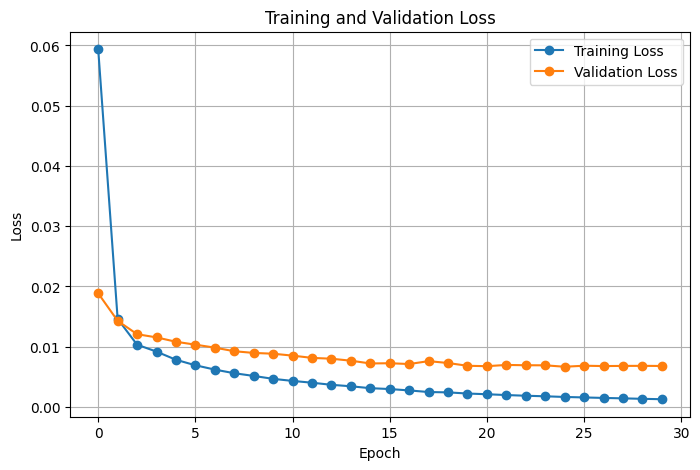

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


<h3>2.Training and validation accuracy

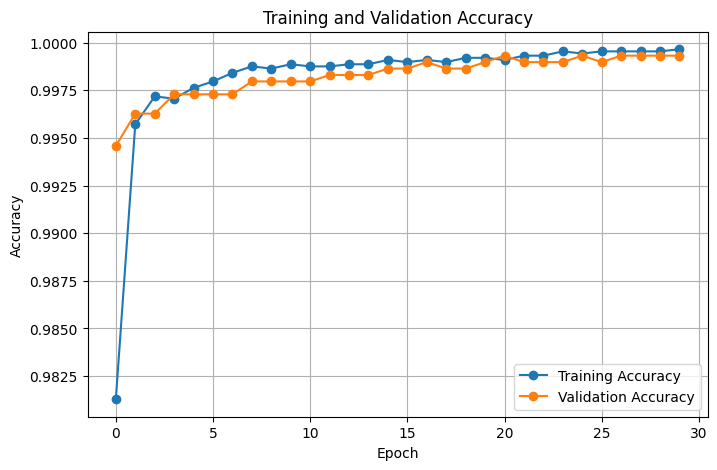

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc_history, label='Training Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


<h4>Softmax regression

In [10]:

input_dim = 784
num_classes = 10
lr = 0.01
num_epochs = 30

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

#initalize weights and bias
W = torch.randn(input_dim, num_classes, requires_grad=True)
W.data *= 0.01
b = torch.zeros(num_classes, requires_grad=True)

for epoch in range(num_epochs):
    
    train_loss = 0.0
    train_correct_preds = 0
    train_samples = 0

    for images, labels in train_loader:

        logits = images @ W + b  
        loss = F.cross_entropy(logits, labels, reduction='sum')
        loss.backward()

        with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
            W.grad.zero_()
            b.grad.zero_()

        train_loss += loss.item() 
        train_samples += labels.size(0)
        predicted_classes = torch.argmax(logits, dim=1)
        train_correct_preds += (predicted_classes == labels).sum().item()

    avg_train_loss = train_loss / train_samples
    avg_train_acc = train_correct_preds / train_samples
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)
    
    val_loss = 0.0
    val_correct_preds = 0
    val_samples = 0
    with torch.no_grad():
        
        for images, labels in val_loader:
            logits = images @ W + b
            loss = F.cross_entropy(logits, labels, reduction='sum')
            val_loss += loss.item()
            
            predicted_classes = torch.argmax(logits, dim=1)
            val_correct_preds += (predicted_classes == labels).sum().item()
            val_samples += labels.size(0)
            
    avg_val_loss = val_loss / val_samples
    avg_val_acc = val_correct_preds / val_samples
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(avg_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {avg_train_acc*100:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {avg_val_acc*100:.2f}%")

Epoch [1/30] | Train Loss: 0.3963 | Train Acc: 88.44% | Val Loss: 0.3378 | Val Acc: 90.20%
Epoch [2/30] | Train Loss: 0.3101 | Train Acc: 91.17% | Val Loss: 0.3047 | Val Acc: 91.58%
Epoch [3/30] | Train Loss: 0.2950 | Train Acc: 91.69% | Val Loss: 0.3005 | Val Acc: 91.75%
Epoch [4/30] | Train Loss: 0.2841 | Train Acc: 92.01% | Val Loss: 0.3119 | Val Acc: 91.29%
Epoch [5/30] | Train Loss: 0.2795 | Train Acc: 92.08% | Val Loss: 0.3107 | Val Acc: 91.36%
Epoch [6/30] | Train Loss: 0.2756 | Train Acc: 92.24% | Val Loss: 0.3028 | Val Acc: 91.58%
Epoch [7/30] | Train Loss: 0.2724 | Train Acc: 92.41% | Val Loss: 0.3046 | Val Acc: 91.56%
Epoch [8/30] | Train Loss: 0.2704 | Train Acc: 92.33% | Val Loss: 0.3061 | Val Acc: 91.66%
Epoch [9/30] | Train Loss: 0.2690 | Train Acc: 92.56% | Val Loss: 0.3165 | Val Acc: 91.09%
Epoch [10/30] | Train Loss: 0.2659 | Train Acc: 92.63% | Val Loss: 0.3059 | Val Acc: 91.55%
Epoch [11/30] | Train Loss: 0.2627 | Train Acc: 92.66% | Val Loss: 0.3043 | Val Acc: 91.6

<h4> Test evaluation

In [11]:

test_correct_preds = 0
test_total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad(): 
    
    for images, labels in test_loader: 
        
        logits = images @ W + b
        predicted_classes = torch.argmax(logits, dim=1)
        
        test_correct_preds += (predicted_classes == labels).sum().item()
        test_total_samples += labels.size(0)
        
        # for confusion Matrix 
        # .cpu() moves data from GPU (if used) back to CPU
        all_preds.extend(predicted_classes.cpu())
        all_labels.extend(labels.cpu())

# Calculate and print final test accuracy
final_test_accuracy = test_correct_preds / test_total_samples
print(f"Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

Final Test Accuracy: 92.14%


In [ ]:

confusion_matrix = torch.zeros((10, 10), dtype=torch.int64)

# Loop through all the collected predictions and labels
for label, pred in zip(all_labels, all_preds):
    # Increment the count at the (actual, predicted) cell
    confusion_matrix[label, pred] += 1 

print("\n Confusion Matrix Manual")
print(confusion_matrix)

correct_per_class = confusion_matrix.diag()

# Get the total number of samples for each class (the row sums)
total_per_class = confusion_matrix.sum(dim=1)

# calculate the accuracy for each class
# Add 1e-6 to avoid division by zero if a class has no samples
per_class_accuracy = correct_per_class.float() / (total_per_class.float() + 1e-6)

print("\n--- Per-Class Accuracy ---")
for i in range(10):
    print(f"Class {i}: {per_class_accuracy[i] * 100:.2f}%")


 Confusion Matrix Manual
tensor([[1339,    0,    3,    1,    2,   14,    8,    3,    7,    3],
        [   1, 1539,    4,    6,    2,    6,    0,    4,   13,    0],
        [  13,   17, 1236,   27,   14,    7,   23,   19,   36,    6],
        [  11,   10,   25, 1251,    1,   64,   10,   13,   35,    9],
        [   4,    9,    4,    6, 1275,    2,    9,    3,   14,   39],
        [  13,    5,   12,   29,    7, 1112,   31,    3,   42,    9],
        [  10,    4,    6,    1,    8,   17, 1322,    2,    5,    0],
        [   4,    5,   20,   10,    9,    3,    0, 1367,    6,   35],
        [  12,   24,   19,   18,    8,   39,   17,    6, 1217,    5],
        [  10,    7,    2,   15,   44,   13,    2,   38,   19, 1241]])

--- Per-Class Accuracy ---
Class 0: 97.03%
Class 1: 97.71%
Class 2: 88.41%
Class 3: 87.54%
Class 4: 93.41%
Class 5: 88.04%
Class 6: 96.15%
Class 7: 93.69%
Class 8: 89.16%
Class 9: 89.22%


<h3>Compare with PyTorch's built-in implementations for verification

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

input_dim = 784
num_classes = 10
lr = 0.01
num_epochs = 30

# PyTorch built-in linear model
model = nn.Linear(input_dim, num_classes)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=lr)


In [15]:
train_loss_history_nn = []
train_acc_history_nn = []
val_loss_history_nn = []
val_acc_history_nn = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_samples = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)  
        predicted_classes = torch.argmax(outputs, dim=1)
        train_correct += (predicted_classes == labels).sum().item()
        train_samples += labels.size(0)
    
    avg_train_loss = train_loss / train_samples
    avg_train_acc = train_correct / train_samples
    train_loss_history_nn.append(avg_train_loss)
    train_acc_history_nn.append(avg_train_acc)
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            predicted_classes = torch.argmax(outputs, dim=1)
            val_correct += (predicted_classes == labels).sum().item()
            val_samples += labels.size(0)
    
    avg_val_loss = val_loss / val_samples
    avg_val_acc = val_correct / val_samples
    val_loss_history_nn.append(avg_val_loss)
    val_acc_history_nn.append(avg_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {avg_train_acc*100:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {avg_val_acc*100:.2f}%")


Epoch [1/30] | Train Loss: 1.1090 | Train Acc: 78.09% | Val Loss: 0.7149 | Val Acc: 84.64%
Epoch [2/30] | Train Loss: 0.6177 | Train Acc: 85.97% | Val Loss: 0.5583 | Val Acc: 86.39%
Epoch [3/30] | Train Loss: 0.5176 | Train Acc: 87.35% | Val Loss: 0.4940 | Val Acc: 87.61%
Epoch [4/30] | Train Loss: 0.4690 | Train Acc: 88.12% | Val Loss: 0.4580 | Val Acc: 88.10%
Epoch [5/30] | Train Loss: 0.4392 | Train Acc: 88.70% | Val Loss: 0.4343 | Val Acc: 88.60%
Epoch [6/30] | Train Loss: 0.4185 | Train Acc: 89.04% | Val Loss: 0.4170 | Val Acc: 88.89%
Epoch [7/30] | Train Loss: 0.4029 | Train Acc: 89.42% | Val Loss: 0.4042 | Val Acc: 89.07%
Epoch [8/30] | Train Loss: 0.3908 | Train Acc: 89.59% | Val Loss: 0.3940 | Val Acc: 89.36%
Epoch [9/30] | Train Loss: 0.3810 | Train Acc: 89.78% | Val Loss: 0.3853 | Val Acc: 89.58%
Epoch [10/30] | Train Loss: 0.3727 | Train Acc: 89.98% | Val Loss: 0.3782 | Val Acc: 89.67%
Epoch [11/30] | Train Loss: 0.3658 | Train Acc: 90.10% | Val Loss: 0.3721 | Val Acc: 89.8

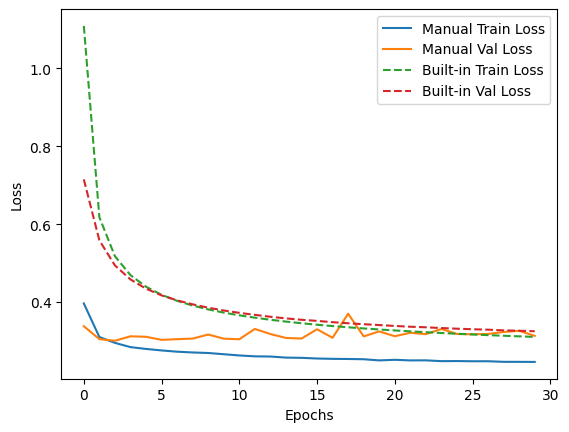

In [20]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Manual Train Loss')
plt.plot(val_loss_history, label='Manual Val Loss')
plt.plot(train_loss_history_nn, label='Built-in Train Loss', linestyle='--')
plt.plot(val_loss_history_nn, label='Built-in Val Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<h4>Test evaluation

In [18]:

test_correct = 0
test_total = 0
all_preds_nn = []
all_labels_nn = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted_classes = torch.argmax(outputs, dim=1)
        test_correct += (predicted_classes == labels).sum().item()
        test_total += labels.size(0)
        
        all_preds_nn.extend(predicted_classes.cpu().numpy())
        all_labels_nn.extend(labels.cpu().numpy())

final_test_accuracy_builtin = test_correct / test_total
print(f"Final Test Accuracy (Built-in): {final_test_accuracy_builtin*100:.2f}%")


Final Test Accuracy (Built-in): 90.86%


In [22]:
print(f"Manual Test Accuracy: {final_test_accuracy*100:.2f}%")
print(f"Built-in Test Accuracy: {final_test_accuracy_builtin*100:.2f}%")


Manual Test Accuracy: 92.14%
Built-in Test Accuracy: 90.86%


<h3>plot Curves

<h3>1.training vs validation loss

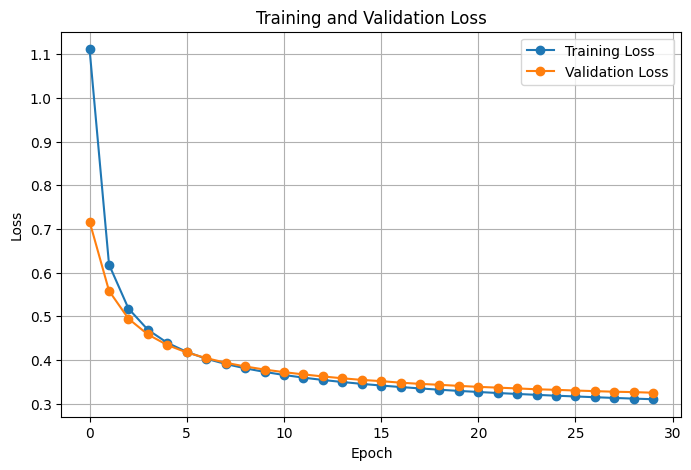

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


<h3>2.Training and validation accuracy

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc_history, label='Training Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

# Part B: Neural Network Implementation

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SimpleFNN(nn.Module):
    def __init__(self,num_classes=10):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)
        # --- Weight Initialization ---
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
import torchvision
import torchvision.transforms as transforms

# Define the transform: Convert images to PyTorch Tensors
transform = transforms.ToTensor()
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


In [34]:
from torch.utils.data import DataLoader , random_split
train_size = 50000
validation_size = 10000

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

BATCH_SIZE = 64

train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation= DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
import torch.optim as optim


model = SimpleFNN()
model.to(device)

loss=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [74]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy 


#
NUM_EPOCHS = 30
NUM_RUNS = 5  #  Run the experiment 5 times
PATIENCE = 5

all_runs_train_loss = []
all_runs_val_loss = []
all_runs_train_acc = []
all_runs_val_acc = []


for i in range(NUM_RUNS):
    print(f"--- Run {i+1}/{NUM_RUNS} ---")
    
    # --- 4. Initialize Model, Loss, and Optimizer INSIDE the loop ---
    # This is CRITICAL. Each run must start with a fresh, untrained model.
    model = SimpleFNN()
    model.to(device)
    loss_fn = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    min_val_loss = float('inf')                
    patience_counter = 0                          
    best_model_state = None                       

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        for images,labels in train:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs=model(images)

            l = loss_fn(outputs,labels) 
            l.backward()
            optimizer.step()
            
            running_loss += l.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
       
        epoch_loss = running_loss / len(train)
        train_loss_history.append(epoch_loss)
        epoch_train_acc = 100 * train_correct / train_total
        train_acc_history.append(epoch_train_acc)

        model.eval() 
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in validation:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                l = loss_fn(outputs, labels) 
                val_running_loss += l.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(validation)
        epoch_val_acc = 100 * val_correct / val_total
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)
        
        # print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
        #       f'Train Loss: {epoch_loss:.4f}, '
        #       f'Val Loss: {epoch_val_loss:.4f}')
              
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f'Run {i+1}: Early stopping at epoch {epoch+1}.')
            break
            
   
    num_epochs_completed = len(train_loss_history)
    if num_epochs_completed < NUM_EPOCHS:
        padding_len = NUM_EPOCHS - num_epochs_completed
        # Pad with the last recorded value
        train_loss_history.extend([train_loss_history[-1]] * padding_len)
        val_loss_history.extend([val_loss_history[-1]] * padding_len)
        train_acc_history.extend([train_acc_history[-1]] * padding_len)
        val_acc_history.extend([val_acc_history[-1]] * padding_len)

    all_runs_train_loss.append(train_loss_history)
    all_runs_val_loss.append(val_loss_history)
    all_runs_train_acc.append(train_acc_history)
    all_runs_val_acc.append(val_acc_history)
    

print("\n--- All runs complete.---")

arr_train_loss = np.array(all_runs_train_loss)
arr_val_loss = np.array(all_runs_val_loss)
arr_train_acc = np.array(all_runs_train_acc)
arr_val_acc = np.array(all_runs_val_acc)

mean_train_loss = np.mean(arr_train_loss, axis=0)
std_train_loss = np.std(arr_train_loss, axis=0)
mean_val_loss = np.mean(arr_val_loss, axis=0)
std_val_loss = np.std(arr_val_loss, axis=0)

mean_train_acc = np.mean(arr_train_acc, axis=0)
std_train_acc = np.std(arr_train_acc, axis=0)
mean_val_acc = np.mean(arr_val_acc, axis=0)
std_val_acc = np.std(arr_val_acc, axis=0)






--- Run 1/5 ---
Run 1: Early stopping at epoch 20.
--- Run 2/5 ---
Run 2: Early stopping at epoch 18.
--- Run 3/5 ---
Run 3: Early stopping at epoch 16.
--- Run 4/5 ---
Run 4: Early stopping at epoch 18.
--- Run 5/5 ---
Run 5: Early stopping at epoch 17.

--- All runs complete.---


In [ ]:

model.eval() 

test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        l = loss(outputs, labels)
        val_running_loss += l.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
final_test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

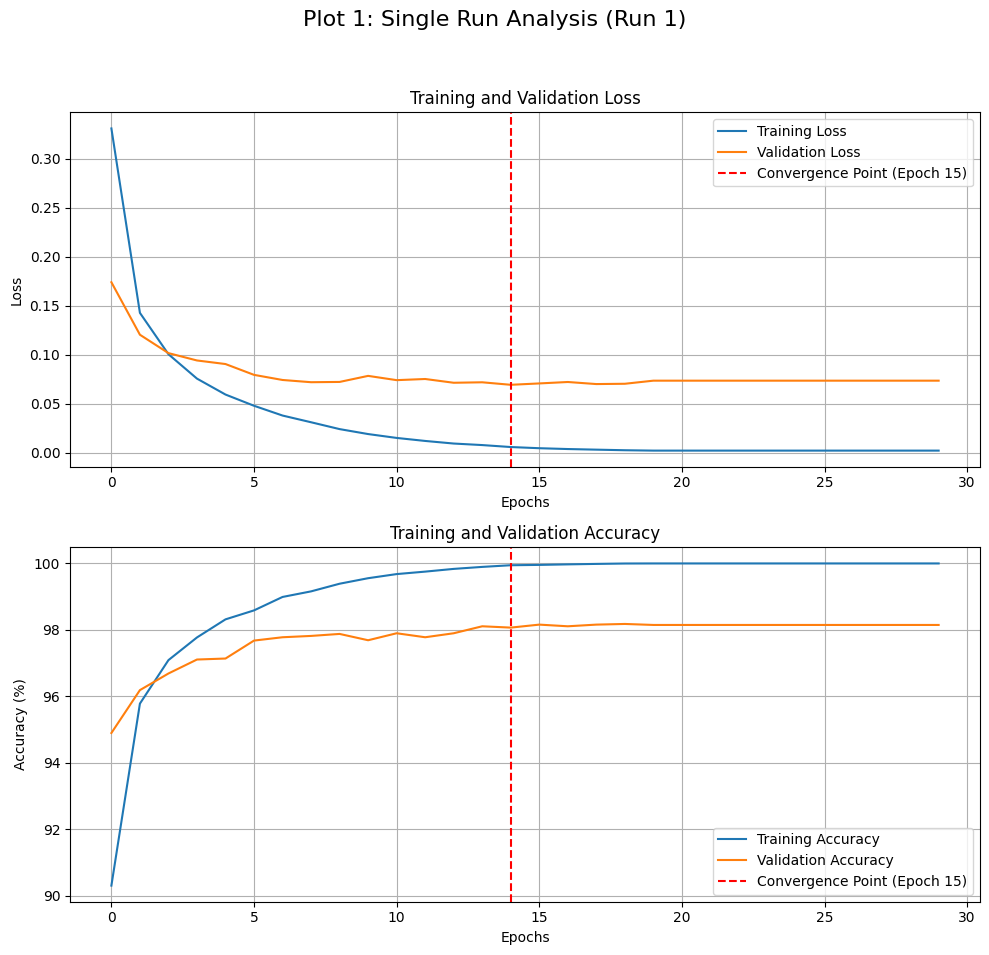

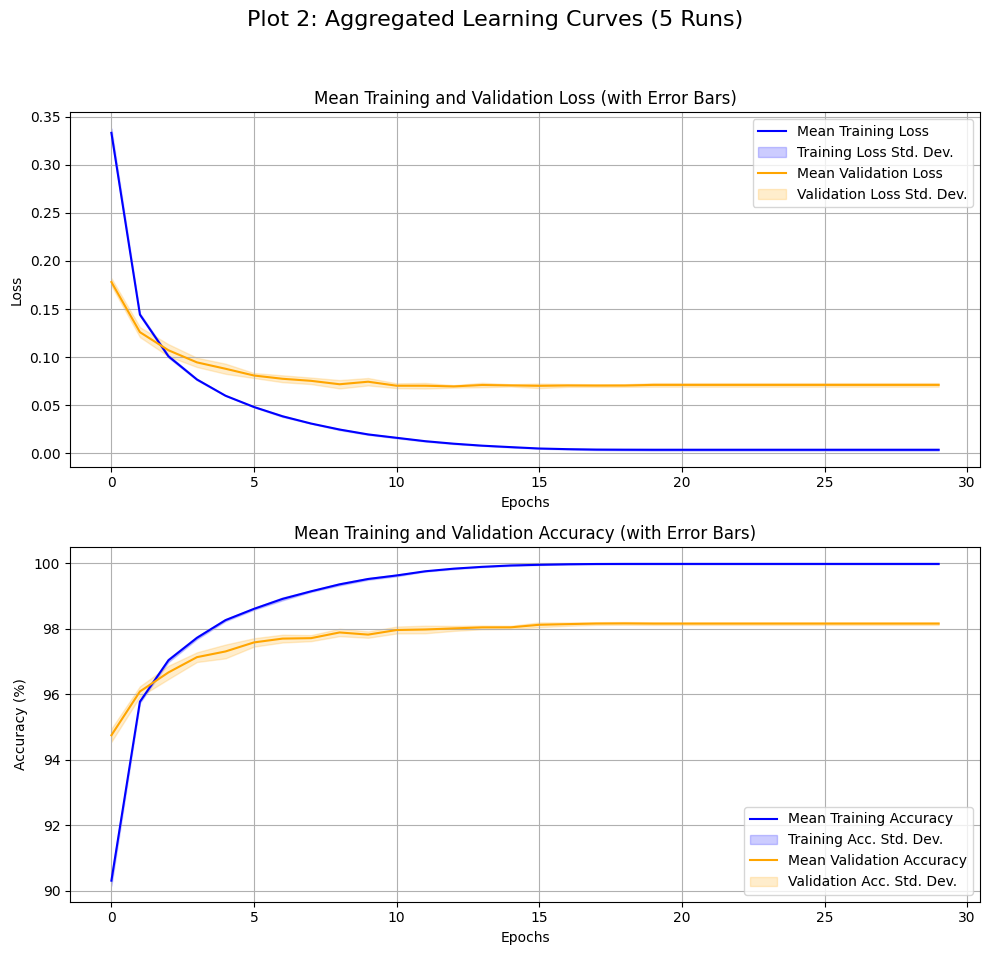

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# --- Plot 1: Single Run Analysis (from Run 1) ---

# Get data from the *first* run
run1_train_loss = all_runs_train_loss[0]
run1_val_loss = all_runs_val_loss[0]
run1_train_acc = all_runs_train_acc[0]
run1_val_acc = all_runs_val_acc[0]

run1_best_epoch = np.argmin(run1_val_loss) 

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig1.suptitle('Plot 1: Single Run Analysis (Run 1)', fontsize=16)

# Plot 1a: Loss
ax1.plot(run1_train_loss, label='Training Loss')
ax1.plot(run1_val_loss, label='Validation Loss')
# This line will now work perfectly
ax1.axvline(x=run1_best_epoch, color='r', linestyle='--', 
            label=f'Convergence Point (Epoch {run1_best_epoch+1})') 
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot 1b: Accuracy
ax2.plot(run1_train_acc, label='Training Accuracy')
ax2.plot(run1_val_acc, label='Validation Accuracy')
# This line will also work perfectly
ax2.axvline(x=run1_best_epoch, color='r', linestyle='--', 
            label=f'Convergence Point (Epoch {run1_best_epoch+1})')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()


# --- Plot 2: Aggregated Learning Curves (All Runs) ---

# • Learning curves with error bars

epochs = range(NUM_EPOCHS)
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 10))
fig2.suptitle(f'Plot 2: Aggregated Learning Curves ({NUM_RUNS} Runs)', fontsize=16)

# Plot 2a: Loss with Error Bars
ax3.plot(epochs, mean_train_loss, label='Mean Training Loss', color='blue')
ax3.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, 
                 color='blue', alpha=0.2, label='Training Loss Std. Dev.')

ax3.plot(epochs, mean_val_loss, label='Mean Validation Loss', color='orange')
ax3.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, 
                 color='orange', alpha=0.2, label='Validation Loss Std. Dev.')

ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_title('Mean Training and Validation Loss (with Error Bars)')
ax3.legend()
ax3.grid(True)

# Plot 2b: Accuracy with Error Bars
ax4.plot(epochs, mean_train_acc, label='Mean Training Accuracy', color='blue')
ax4.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, 
                 color='blue', alpha=0.2, label='Training Acc. Std. Dev.')

ax4.plot(epochs, mean_val_acc, label='Mean Validation Accuracy', color='orange')
ax4.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, 
                 color='orange', alpha=0.2, label='Validation Acc. Std. Dev.')

ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Mean Training and Validation Accuracy (with Error Bars)')
ax4.legend()
ax4.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

# Part C: Comprehensive Analysis

### 1. setup

In [49]:
def test_model_simpleFNN(l_r,b_size,hidden_sizes,n_epochs, testing = False):
    # flexible model class
    class SimpleFNN_modified(nn.Module):
        def __init__(self,num_classes=10):
            super(SimpleFNN_modified, self).__init__()
            layers = []
            prev_size = 784
            for h_size in hidden_sizes:
                layers.append(nn.Linear(prev_size,h_size))
                prev_size = h_size
            self.hidden_layers = nn.ModuleList(layers)
            self.out_layer = nn.Linear(prev_size,num_classes) 
            # self.fc1 = nn.Linear(784, 128)
            # self.fc2 = nn.Linear(128, 256)
            # self.fc3 = nn.Linear(256, num_classes)
            # --- Weight Initialization ---
            for layer in self.hidden_layers:
                nn.init.kaiming_normal_(layer.weight)
            nn.init.xavier_normal_(self.out_layer.weight)
            # nn.init.kaiming_normal_(self.fc1.weight)
            # nn.init.kaiming_normal_(self.fc2.weight)
            # nn.init.xavier_normal_(self.fc3.weight)
        def forward(self, x):
            x = x.view(-1, 784)
            # x = F.relu(self.fc1(x))
            # x= F.relu(self.fc2(x))
            for layer in self.hidden_layers:
                x = F.relu(layer(x))
            x = self.out_layer(x)
            return x
    # dataset creation
    transform = transforms.ToTensor()
    train_data_MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_data_MNIST  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    full_data_MNIST = ConcatDataset([train_data_MNIST, test_data_MNIST])
    targets = np.concatenate((train_data_MNIST.targets.numpy(),test_data_MNIST.targets.numpy()))
    indices = np.arange(len(targets))

    train_idx, temp_idx, y_train, y_temp = train_test_split(indices, targets, test_size=0.4, stratify=targets, random_state=42)
    val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    train_dataset = Subset(full_data_MNIST, train_idx)
    val_dataset   = Subset(full_data_MNIST, val_idx)
    test_dataset  = Subset(full_data_MNIST, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=b_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)
    # model instance
    model = SimpleFNN_modified()
    model.to(device)

    loss=nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=l_r, momentum=0.9)
    # testing 
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        for images,labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs=model(images)

            l=loss(outputs,labels)
            l.backward()
            optimizer.step()
            
            running_loss += l.item()
            # Get training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    
        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        epoch_train_acc = 100 * train_correct / train_total
        train_acc_history.append(epoch_train_acc)


        model.eval() 
        correct = 0
        total = 0
        val_running_loss = 0.0

        with torch.no_grad(): 
            for images, labels in val_loader: 
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                l= loss(outputs, labels) 
                val_running_loss += l.item()
                correct+=(predicted==labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total

        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{n_epochs}], '
        f'Train Loss: {epoch_loss:.4f}, '
        f'Train Acc: {epoch_train_acc:.2f}%, '
        f'Val Loss: {epoch_val_loss:.4f}, '
        f'Val Acc: {epoch_val_acc:.2f}%')
        
    # testing mode only
    test_loss_history = []
    test_acc_history = []
    test_y_true = []
    test_y_pred =  []

    if testing:
        model.eval()
        correct = 0
        total = 0
        test_loss = 0
        with torch.no_grad():
            for image, label in test_loader:
                image  = image.to(device)
                label = label.to(device)
                outputs = model(image)
                loss_val = loss(outputs, label)
                test_loss += loss_val.item()
                _, preds = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (preds == label).sum().item()
                test_y_true.extend(label.cpu().numpy())
                test_y_pred.extend(preds.cpu().numpy())
                
        test_acc = 100 * correct / total
        test_loss = test_loss / len(test_loader)
        test_acc_history.append(test_acc)
        test_loss_history.append(test_loss)

        print(f"Final Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, model, test_loss_history, test_acc_history,  test_y_true, test_y_pred
    

        

### c1. hyperparameter analysis

#### learning rate

In [25]:
rates = [0.001, 0.01, 0.1, 1.0]
results_lr = {}
for lr in rates:
    print(f"\t * Training with learning rate = {lr} *")
    train_loss, val_loss, train_acc, val_acc, model = test_model_simpleFNN(l_r=lr, b_size=64, hidden_sizes=[128,256], n_epochs=8)
    results_lr[lr] = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc
    }

	 * Training with learning rate = 0.001 *
Epoch [1/8], Train Loss: 0.8917, Train Acc: 76.34%, Val Loss: 0.4439, Val Acc: 88.09%
Epoch [2/8], Train Loss: 0.3772, Train Acc: 89.39%, Val Loss: 0.3438, Val Acc: 90.33%
Epoch [3/8], Train Loss: 0.3108, Train Acc: 91.10%, Val Loss: 0.3020, Val Acc: 91.55%
Epoch [4/8], Train Loss: 0.2764, Train Acc: 92.04%, Val Loss: 0.2765, Val Acc: 92.16%
Epoch [5/8], Train Loss: 0.2513, Train Acc: 92.79%, Val Loss: 0.2576, Val Acc: 92.72%
Epoch [6/8], Train Loss: 0.2330, Train Acc: 93.29%, Val Loss: 0.2425, Val Acc: 93.19%
Epoch [7/8], Train Loss: 0.2169, Train Acc: 93.86%, Val Loss: 0.2323, Val Acc: 93.39%
Epoch [8/8], Train Loss: 0.2030, Train Acc: 94.25%, Val Loss: 0.2208, Val Acc: 93.76%
	 * Training with learning rate = 0.01 *
Epoch [1/8], Train Loss: 0.3735, Train Acc: 88.91%, Val Loss: 0.2085, Val Acc: 93.98%
Epoch [2/8], Train Loss: 0.1669, Train Acc: 95.14%, Val Loss: 0.1651, Val Acc: 95.02%
Epoch [3/8], Train Loss: 0.1208, Train Acc: 96.45%, Val L

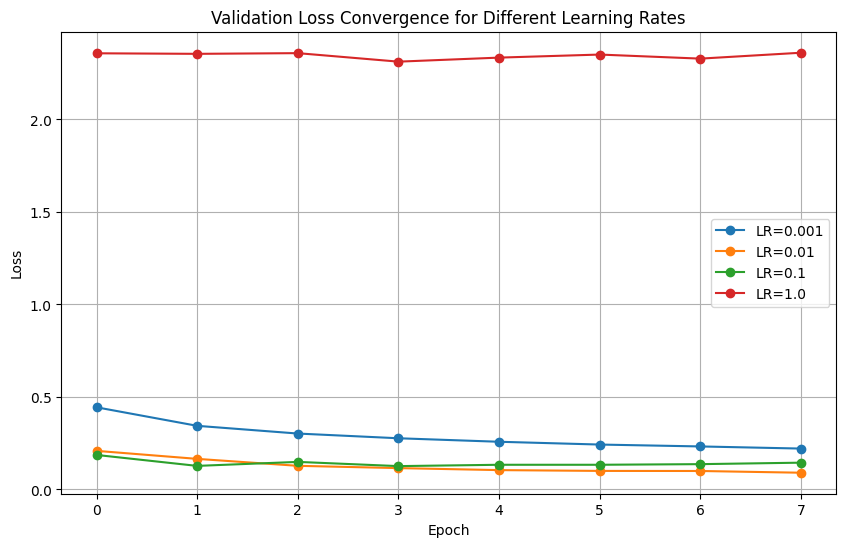

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for lr, history in results_lr.items():
    plt.plot(history["val_loss"], marker='o', label=f"LR={lr}")
plt.title("Validation Loss Convergence for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


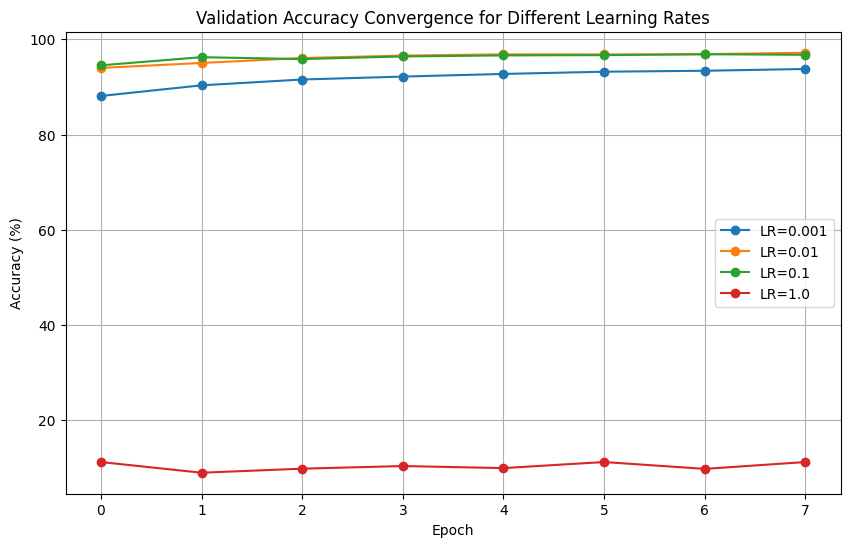

In [32]:
plt.figure(figsize=(10,6))
for lr, history in results_lr.items():
    plt.plot(history["val_acc"], marker='o', label=f"LR={lr}")
plt.title("Validation Accuracy Convergence for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()



Results show that:
* **0.001** accuracy is stable (steady increase) but its loss is decreasing relatively slow.
* **0.01** accuracy is steadily increasing too, but loss is decreasing much faster than the previous one.
* **0.1** loss is approximately the same as 0.01, but it is noticed that between epoch 1 and 2 the accuracy is starting to oscillate, which indicates instability.
* **1.0** is both not accurate and doesn’t optimize the loss, indicating high overshooting.

#### batch sizes

In [33]:
batches = [16, 32, 64, 128]
results_batch = {}
for b in batches:
    print(f"\t * Training with batch size = {b} *")
    train_loss, val_loss, train_acc, val_acc, model = test_model_simpleFNN(l_r=0.01, b_size=b, hidden_sizes=[128,256], n_epochs=8)
    results_batch[b] = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc
    }

	 * Training with batch size = 16 *
Epoch [1/8], Train Loss: 0.2579, Train Acc: 91.89%, Val Loss: 0.1493, Val Acc: 95.49%
Epoch [2/8], Train Loss: 0.1134, Train Acc: 96.40%, Val Loss: 0.1219, Val Acc: 96.22%
Epoch [3/8], Train Loss: 0.0756, Train Acc: 97.56%, Val Loss: 0.1055, Val Acc: 96.89%
Epoch [4/8], Train Loss: 0.0564, Train Acc: 98.24%, Val Loss: 0.0993, Val Acc: 96.97%
Epoch [5/8], Train Loss: 0.0416, Train Acc: 98.68%, Val Loss: 0.1008, Val Acc: 97.19%
Epoch [6/8], Train Loss: 0.0294, Train Acc: 99.03%, Val Loss: 0.1018, Val Acc: 97.20%
Epoch [7/8], Train Loss: 0.0232, Train Acc: 99.21%, Val Loss: 0.1073, Val Acc: 97.29%
Epoch [8/8], Train Loss: 0.0182, Train Acc: 99.42%, Val Loss: 0.0990, Val Acc: 97.50%
	 * Training with batch size = 32 *
Epoch [1/8], Train Loss: 0.2957, Train Acc: 91.06%, Val Loss: 0.1531, Val Acc: 95.31%
Epoch [2/8], Train Loss: 0.1232, Train Acc: 96.22%, Val Loss: 0.1189, Val Acc: 96.32%
Epoch [3/8], Train Loss: 0.0862, Train Acc: 97.35%, Val Loss: 0.1069

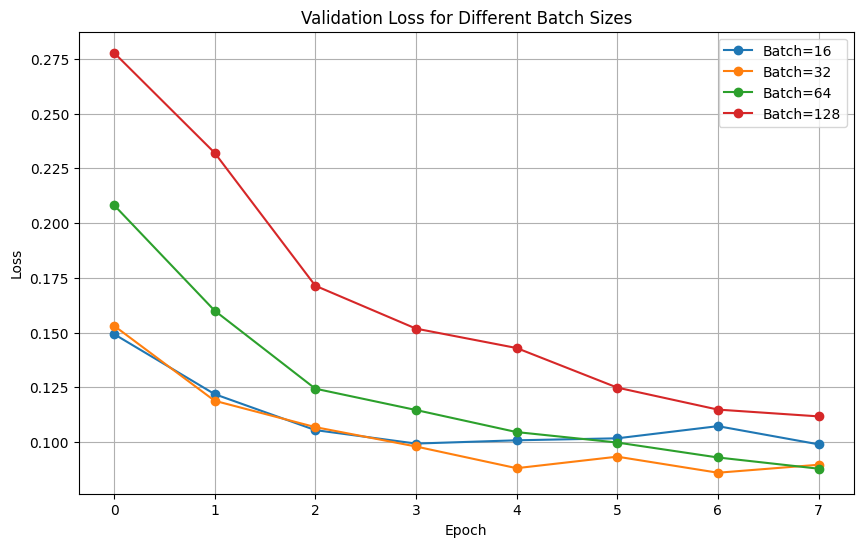

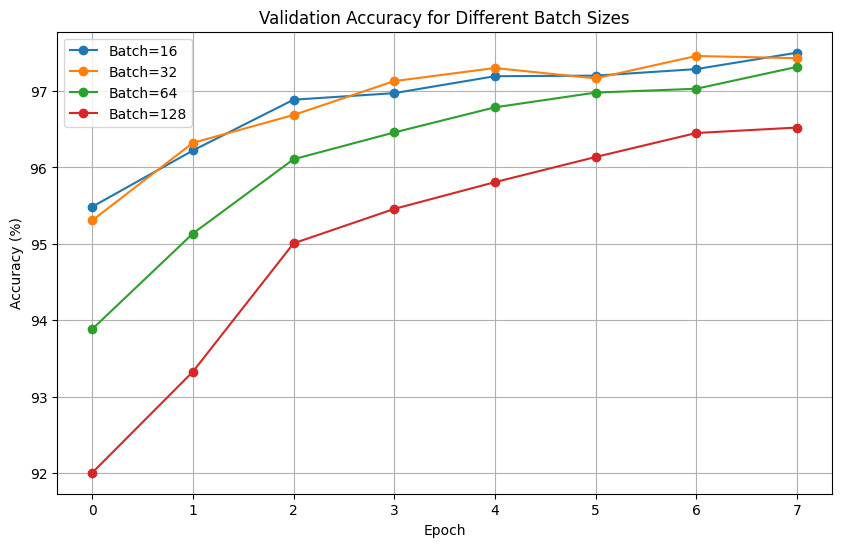

In [34]:
plt.figure(figsize=(10,6))
for b, history in results_batch.items():
    plt.plot(history["val_loss"], marker='o', label=f"Batch={b}")
plt.title("Validation Loss for Different Batch Sizes")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for b, history in results_batch.items():
    plt.plot(history["val_acc"], marker='o', label=f"Batch={b}")
plt.title("Validation Accuracy for Different Batch Sizes")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()



Results show that:
* **smaller batches(16,32)** has more gradient noise as the loss value is oscillating but in terms of accuracy performed better than others
* **64** less accuracy but very close to smaller batches while waaaaaay more steady gradient with minimum fluctutions in the loss
* **128** steady gradient where loss is always decreasing but slightly lower loss and accuracy optimization as it is more "careful" so slow 

#### Architecture

In [45]:
import time

architectures = {
    "A_[64,64]": [64, 64],
    "B_[128,128]": [128, 128],
    "C_[256,128]": [256, 128],
    "D_[128,256,128]": [128, 256, 128],
    "E_[256,256,128,64]": [256, 256, 128, 64],
    "F_[512,256,128,64,32]": [512, 256, 128, 64, 32]
}

results_arch = {}

for name, arch in architectures.items():
    print(f"\t * Training {name} *")
    start_time = time.time()

    train_loss, val_loss, train_acc, val_acc, model = test_model_simpleFNN(
        l_r=0.01,
        b_size=64,
        hidden_sizes=arch,
        n_epochs=8
    )

    elapsed_time = time.time() - start_time

    results_arch[name] = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model,
        "time": elapsed_time
    }


	 * Training A_[64,64] *
Epoch [1/8], Train Loss: 0.4353, Train Acc: 87.08%, Val Loss: 0.2736, Val Acc: 91.69%
Epoch [2/8], Train Loss: 0.2047, Train Acc: 94.04%, Val Loss: 0.1870, Val Acc: 94.59%
Epoch [3/8], Train Loss: 0.1517, Train Acc: 95.46%, Val Loss: 0.1560, Val Acc: 95.38%
Epoch [4/8], Train Loss: 0.1229, Train Acc: 96.26%, Val Loss: 0.1383, Val Acc: 95.76%
Epoch [5/8], Train Loss: 0.1006, Train Acc: 97.02%, Val Loss: 0.1330, Val Acc: 95.84%
Epoch [6/8], Train Loss: 0.0877, Train Acc: 97.25%, Val Loss: 0.1217, Val Acc: 96.37%
Epoch [7/8], Train Loss: 0.0747, Train Acc: 97.71%, Val Loss: 0.1207, Val Acc: 96.29%
Epoch [8/8], Train Loss: 0.0653, Train Acc: 97.98%, Val Loss: 0.1230, Val Acc: 96.36%
	 * Training B_[128,128] *
Epoch [1/8], Train Loss: 0.3820, Train Acc: 88.85%, Val Loss: 0.2238, Val Acc: 93.42%
Epoch [2/8], Train Loss: 0.1730, Train Acc: 94.83%, Val Loss: 0.1610, Val Acc: 95.34%
Epoch [3/8], Train Loss: 0.1249, Train Acc: 96.27%, Val Loss: 0.1515, Val Acc: 95.42%
Ep

In [ ]:
from tabulate import tabulate

summary = []

for name, info in results_arch.items():
    model = info["model"] 
    params = sum(p.numel() for p in model.parameters())
    final_acc = info["val_acc"][-1]
    final_loss = info["val_loss"][-1]
    elapsed = info["time"]

    summary.append([
        name,
        len(list(model.hidden_layers)),
        f"{params:,}",
        f"{final_acc:.2f}",
        f"{final_loss:.4f}",
        f"{elapsed:.1f}"
    ])

headers = ["Model", "Hidden Layers", "Params", "Final Val Acc (%)", "Final Val Loss", "Train Time (s)"]
print(tabulate(summary, headers=headers, tablefmt="github"))


| Model                 |   Hidden Layers | Params   |   Final Val Acc (%) |   Final Val Loss |   Train Time (s) |
|-----------------------|-----------------|----------|---------------------|------------------|------------------|
| A_[64,64]             |               2 | 55,050   |               96.36 |           0.123  |             49.8 |
| B_[128,128]           |               2 | 118,282  |               97.11 |           0.0969 |             50.3 |
| C_[256,128]           |               2 | 235,146  |               97.29 |           0.0901 |             51.8 |
| D_[128,256,128]       |               3 | 167,690  |               97.27 |           0.0943 |             51.9 |
| E_[256,256,128,64]    |               4 | 308,554  |               97.21 |           0.1051 |             55.6 |
| F_[512,256,128,64,32] |               5 | 576,810  |               97.39 |           0.1073 |             61.3 |



Results show that:
* **B,C,D** stable(loss is small) and high accuracy while maintaining a moderate number of params
* **A** small model with very acceptable performance
* **E and F** Much larger models with large number of parameters (higher computation cost) with marginal improvement in accuracy compared to other models and potential instability indicated by relatively higher loss 

I will choose D as it has that moderate spot between params count and performance and stability

### C2 Model Comparison

In [ ]:
_, _, _,_, model_nn, test_loss, test_acc, test_y_true, test_y_pred = test_model_simpleFNN(l_r=0.01, b_size=64, hidden_sizes=[128,256,128], n_epochs=12 , testing=True)



Epoch [1/12], Train Loss: 0.3494, Train Acc: 89.58%, Val Loss: 0.1855, Val Acc: 94.26%
Epoch [2/12], Train Loss: 0.1432, Train Acc: 95.72%, Val Loss: 0.1392, Val Acc: 95.54%
Epoch [3/12], Train Loss: 0.1024, Train Acc: 96.89%, Val Loss: 0.1232, Val Acc: 96.30%
Epoch [4/12], Train Loss: 0.0747, Train Acc: 97.73%, Val Loss: 0.1092, Val Acc: 96.66%
Epoch [5/12], Train Loss: 0.0587, Train Acc: 98.15%, Val Loss: 0.1032, Val Acc: 97.01%
Epoch [6/12], Train Loss: 0.0484, Train Acc: 98.51%, Val Loss: 0.0906, Val Acc: 97.26%
Epoch [7/12], Train Loss: 0.0370, Train Acc: 98.85%, Val Loss: 0.1081, Val Acc: 96.87%
Epoch [8/12], Train Loss: 0.0307, Train Acc: 99.08%, Val Loss: 0.0866, Val Acc: 97.60%
Epoch [9/12], Train Loss: 0.0238, Train Acc: 99.31%, Val Loss: 0.0887, Val Acc: 97.50%
Epoch [10/12], Train Loss: 0.0171, Train Acc: 99.53%, Val Loss: 0.0879, Val Acc: 97.40%
Epoch [11/12], Train Loss: 0.0119, Train Acc: 99.70%, Val Loss: 0.0940, Val Acc: 97.39%
Epoch [12/12], Train Loss: 0.0097, Train 

In [56]:
# Convert lists or tensors to CPU tensors (just in case they are on GPU)
y_true = torch.tensor(test_y_true).cpu()
y_pred = torch.tensor(test_y_pred).cpu()

# Initialize 10x10 matrix for MNIST classes
confusion_matrix = torch.zeros((10, 10), dtype=torch.int64)

# Fill the confusion matrix
for label, pred in zip(y_true, y_pred):
    confusion_matrix[label.long(), pred.long()] += 1

print("\nConfusion Matrix:")
print(confusion_matrix)

# Compute per-class accuracy
correct_per_class = confusion_matrix.diag()
total_per_class = confusion_matrix.sum(dim=1)
per_class_accuracy = correct_per_class.float() / (total_per_class.float() + 1e-6)

print("\n--- Per-Class Accuracy ---")
for i in range(10):
    print(f"Class {i}: {per_class_accuracy[i] * 100:.2f}%")
    
print(f"\nFinal Test Accuracy: {test_acc[-1]:.2f}% ")



Confusion Matrix:
tensor([[1366,    0,    4,    2,    1,    1,    0,    1,    1,    4],
        [   1, 1560,    3,    2,    0,    0,    0,    4,    3,    2],
        [   2,    8, 1364,    3,    5,    0,    2,   11,    2,    1],
        [   0,    1,    9, 1366,    0,   32,    0,   11,    9,    1],
        [   1,    2,    1,    0, 1331,    0,    2,    1,    1,   26],
        [   5,    0,    1,    6,    0, 1230,    4,    0,   10,    7],
        [   7,    3,    1,    0,    9,   10, 1344,    0,    1,    0],
        [   1,    3,    7,    4,    4,    3,    0, 1418,    3,   16],
        [   4,    7,    4,    8,    2,    9,    1,    2, 1319,    9],
        [   1,    2,    0,    3,    7,    6,    1,    6,    2, 1363]])

--- Per-Class Accuracy ---
Class 0: 98.99%
Class 1: 99.05%
Class 2: 97.57%
Class 3: 95.59%
Class 4: 97.51%
Class 5: 97.39%
Class 6: 97.75%
Class 7: 97.19%
Class 8: 96.63%
Class 9: 97.99%

Final Test Accuracy: 97.58% 


```
Confusion Matrix (Logistic)
                     Predicted
                    NEG (0) | POS (1)
---------------------------------------
Actual NEG (0) |   1380   |    1   
---------------------------------------
Actual POS (1) |    1     |   1574 
---------------------------------------

Accuracy from CM: 99.93%
```
---

```
Confusion Matrix (softmax regression)
tensor([[1339,    0,    3,    1,    2,   14,    8,    3,    7,    3],
        [   1, 1539,    4,    6,    2,    6,    0,    4,   13,    0],
        [  13,   17, 1236,   27,   14,    7,   23,   19,   36,    6],
        [  11,   10,   25, 1251,    1,   64,   10,   13,   35,    9],
        [   4,    9,    4,    6, 1275,    2,    9,    3,   14,   39],
        [  13,    5,   12,   29,    7, 1112,   31,    3,   42,    9],
        [  10,    4,    6,    1,    8,   17, 1322,    2,    5,    0],
        [   4,    5,   20,   10,    9,    3,    0, 1367,    6,   35],
        [  12,   24,   19,   18,    8,   39,   17,    6, 1217,    5],
        [  10,    7,    2,   15,   44,   13,    2,   38,   19, 1241]])

--- Per-Class Accuracy ---
Class 0: 97.03%
Class 1: 97.71%
Class 2: 88.41%
Class 3: 87.54%
Class 4: 93.41%
Class 5: 88.04%
Class 6: 96.15%
Class 7: 93.69%
Class 8: 89.16%
Class 9: 89.22%

Final Test Accuracy: 92.14%
```
---
```
Confusion Matrix(Newral Network):
tensor([[1366,    0,    4,    2,    1,    1,    0,    1,    1,    4],
        [   1, 1560,    3,    2,    0,    0,    0,    4,    3,    2],
        [   2,    8, 1364,    3,    5,    0,    2,   11,    2,    1],
        [   0,    1,    9, 1366,    0,   32,    0,   11,    9,    1],
        [   1,    2,    1,    0, 1331,    0,    2,    1,    1,   26],
        [   5,    0,    1,    6,    0, 1230,    4,    0,   10,    7],
        [   7,    3,    1,    0,    9,   10, 1344,    0,    1,    0],
        [   1,    3,    7,    4,    4,    3,    0, 1418,    3,   16],
        [   4,    7,    4,    8,    2,    9,    1,    2, 1319,    9],
        [   1,    2,    0,    3,    7,    6,    1,    6,    2, 1363]])

--- Per-Class Accuracy ---
Class 0: 98.99%
Class 1: 99.05%
Class 2: 97.57%
Class 3: 95.59%
Class 4: 97.51%
Class 5: 97.39%
Class 6: 97.75%
Class 7: 97.19%
Class 8: 96.63%
Class 9: 97.99%

Final Test Accuracy: 97.58%
```


| Model                            | Task Type               | Accuracy (%) | Complexity | Training Time       | 
| -------------------------------- | ----------------------- | ------------ | ---------- | ------------------- | 
| Logistic Regression              | Binary (0 vs 1)         | **99.76%**   | ( O(n * d) )         | Fast (42 Sec/30Epochs)     | 
| Softmax Regression               | Multi-class (10 digits) | **90.93%**   | ( O(n * d * k) )   | Moderate (163 Sec/30Epochs) | 
| Neural Network (3 hidden layers) | Multi-class             | **97.58%**   | ( O(n * d * (params) * k) )       | Slow (~230 Sec/30Epochs)     |

**params = (neurons of one hidden layer * neuron of next layer) for all layer** <br>
**n= number of training samples** <br>
**d = dimension of a sample** <br>
**k = number of classes** <br>

**From prev Results:**
* logistic regression performed exceptionally well as 1 and 0 are binary and mostly linearaly separable with significantly lower computations and training time
* softmax regression struggled (92% accuracy) with non-linear data that may have high similarities evident from confusion matrix like :
    - 2 VS 8
    - 3 VS 5
    - 4 VS 9

* while neural network had high accuracy with non linear data and very low misclassification rate for each class, It required significantly more training and tuning time 

**when to use each:**
* use **logistic regression** for simple binary class classification and linearaly separable data
* use **softmax regression** for multiclass classification that requires fast training time and low model complexity
* use **neural networks** if model complexity and training time is irrelevant *or* when softmax refression performed lower than accuracy requirements as this indicated high non-linearity in training data which neural networks perform best with





# Part D: Advanced Techniques

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class SimpleFNNWithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(SimpleFNNWithDropout, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(784, 128)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(256, num_classes)
        
        # Weight Initialization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def train_model_with_dropout(dropout_rate, train_loader, validation_loader, num_epochs=50):
    model = SimpleFNNWithDropout(dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    history = defaultdict(list)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(validation_loader)
        val_acc = 100 * correct / total
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if epoch % 10 == 9:
            print(f'Dropout {dropout_rate:.1f} - Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n')
    
    return history, model

In [ ]:
# Train models with different dropout rates
dropout_rates = [0.1, 0.3, 0.5, 0.7]
histories = {}
models = {}

for rate in dropout_rates:
    print(f"\nTraining model with dropout rate {rate}")
    history, model = train_model_with_dropout(rate, train_loader, validation_loader)
    histories[rate] = history
    models[rate] = model

## D1. Convolutional Neural Networks 

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)# takes 1 input channel (grayscale), outputs 32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)# takes 32 input channels, outputs 64 complex channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)# downsampling by factor of 2
        self.fc1 = nn.Linear(64 * 7 * 7, 256)# fully connected layer
        self.fc2 = nn.Linear(256, num_classes)# output layer

    def forward(self, x):
        # 1. Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x))) # Output: (batch_size, 32, 14, 14)
        
        # 2. Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x))) # Output: (batch_size, 64, 7, 7)
        
        # 3. Flatten
        x = x.view(x.size(0), -1) # Flattening to (batch_size, 64 * 7 * 7)
        # 4. FC1 -> ReLU -> FC2
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    


In [48]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

# 1. Define Transform with Normalization
# Normalization (0.1307 mean, 0.3081 std) is crucial for stable training.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)) #these values are for MNIST mean and std and already calculated on internet
])

# 2. Load the main Training and Test datasets
full_train_dataset = MNIST('./data', train=True, download=True, transform=transform)
test_dataset = MNIST('./data', train=False, download=True, transform=transform)

# 3. Split the 60,000 images into Training (50,000) and Validation (10,000)
train_size = 50000
validation_size = 10000

train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, validation_size])

# 4. Create the DataLoaders for all three sets
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:

import torch.optim as optim
import numpy as np # Needed for infinity

patience = 5                                    
min_val_loss = float('inf')                   
patience_counter = 0                          
best_model_state = None                       


num_epochs = 20
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []    
model_cnn = SimpleCNN()
model_cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

for epoch in range(num_epochs):
  
    model_cnn.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    epoch_train_acc = 100 * train_correct / train_total
    train_acc_history.append(epoch_train_acc)


    model_cnn.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(validation_loader)
    epoch_val_acc = 100 * val_correct / val_total

    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Train Acc: {epoch_train_acc:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, '
          f'Val Acc: {epoch_val_acc:.2f}%')


    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        patience_counter = 0
        best_model_state = model_cnn.state_dict()
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience counter: {patience_counter}/{patience}')


    if patience_counter >= patience:
        print(f'Early stopping triggered after {patience} epochs with no improvement.')
        break 

if best_model_state:
    model_cnn.load_state_dict(best_model_state)
    print("Loaded best model weights for final testing.")

Epoch [1/20], Train Loss: 0.1534, Train Acc: 95.30%, Val Loss: 0.0703, Val Acc: 97.79%
Epoch [2/20], Train Loss: 0.0426, Train Acc: 98.66%, Val Loss: 0.0520, Val Acc: 98.48%
Epoch [3/20], Train Loss: 0.0275, Train Acc: 99.11%, Val Loss: 0.0474, Val Acc: 98.56%
Epoch [4/20], Train Loss: 0.0203, Train Acc: 99.35%, Val Loss: 0.0412, Val Acc: 98.86%
Epoch [5/20], Train Loss: 0.0149, Train Acc: 99.51%, Val Loss: 0.0510, Val Acc: 98.61%
Validation loss did not improve. Patience counter: 1/5
Epoch [6/20], Train Loss: 0.0115, Train Acc: 99.61%, Val Loss: 0.0535, Val Acc: 98.78%
Validation loss did not improve. Patience counter: 2/5
Epoch [7/20], Train Loss: 0.0111, Train Acc: 99.62%, Val Loss: 0.0428, Val Acc: 98.89%
Validation loss did not improve. Patience counter: 3/5
Epoch [8/20], Train Loss: 0.0087, Train Acc: 99.73%, Val Loss: 0.0585, Val Acc: 98.77%
Validation loss did not improve. Patience counter: 4/5
Epoch [9/20], Train Loss: 0.0072, Train Acc: 99.76%, Val Loss: 0.0453, Val Acc: 98.9

In [53]:
model_cnn
with torch.no_grad(): 
    test_correct = 0
    test_total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
final_test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Final Test Accuracy: 99.24%


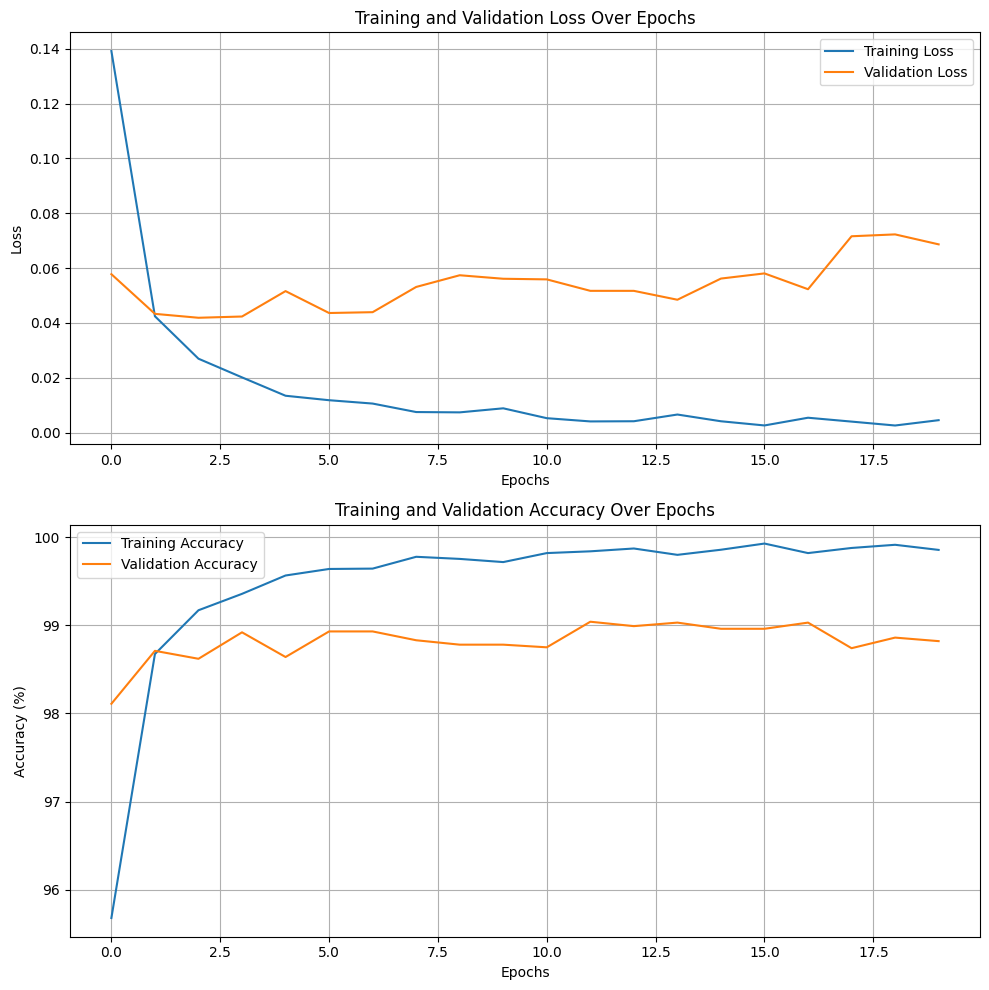

In [42]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Training & Validation Loss
ax1.plot(train_loss_history, label='Training Loss')
ax1.plot(val_loss_history, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.legend()
ax1.grid(True)

# Plot 2: Training & Validation Accuracy
ax2.plot(train_acc_history, label='Training Accuracy')
ax2.plot(val_acc_history, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy Over Epochs')
ax2.legend()
ax2.grid(True)


plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

## D2 Regularization Techniques

In [58]:
class DropOutCNN(nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=10):
        super(DropOutCNN, self).__init__()
        
        # Conv Layer 1 -> BatchNorm -> ReLU -> Pool
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv Layer 2 -> BatchNorm -> ReLU -> Pool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Dropout layer added here
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply BatchNorm after Conv and before ReLU/Pool
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x) # Apply dropout after flattening
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [59]:
class CombinedCNN(nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=10):
        super(CombinedCNN, self).__init__()
        
        # Conv Layer 1 -> BatchNorm -> ReLU -> Pool
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Added Batch Normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv Layer 2 -> BatchNorm -> ReLU -> Pool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Dropout layer added here
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply BatchNorm after Conv and before ReLU/Pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x) # Apply dropout after flattening
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [ ]:
import torch.optim as optim
import numpy as np

PATIENCE = 5
NUM_EPOCHS = 20
DROPOUT_RATES = [0.1, 0.3, 0.5, 0.7]



# Key: dropout rate. Value: dict of history arrays.
all_results_dropout = {}
print("DropOutCNN (NO BATCH NORM)")

for drop in DROPOUT_RATES:
    
    print(f"\n--- Training DropOutCNN (p={drop}) ---")
    
 
    model_cnn = DropOutCNN(dropout_rate=drop).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

    # Reset Early Stopping for each new model
    min_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # History lists for THIS run
    run_train_loss = []
    run_val_loss = []
    run_train_acc = []
    run_val_acc = []
    
    for epoch in range(NUM_EPOCHS):
        model_cnn.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        run_train_loss.append(running_loss / len(train_loader))
        run_train_acc.append(100 * train_correct / train_total)

        model_cnn.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_cnn(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(validation_loader)
        epoch_val_acc = 100 * val_correct / val_total
        run_val_loss.append(epoch_val_loss)
        run_val_acc.append(epoch_val_acc)

      
        print(f'[p={drop}] Epoch [{epoch+1}/{NUM_EPOCHS}]: '
              f'Train Acc: {run_train_acc[-1]:.2f}%, '
              f'Val Acc: {run_val_acc[-1]:.2f}% (Val Loss: {epoch_val_loss:.4f})')

     
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model_cnn.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= PATIENCE:
            print(f'Early stopping triggered.')
            break 

    # Store all history lists for this rate
    all_results_dropout[drop] = {
        'train_loss': run_train_loss,
        'val_loss': run_val_loss,
        'train_acc': run_train_acc,
        'val_acc': run_val_acc
    }
    print(f"--- Finished training for p={drop} ---")

# Combined Analysis (CombinedCNN - With BN) 

# Dictionary to store all results
all_results_combined = {}

print("CombinedCNN (WITH BATCH NORM)")


for drop in DROPOUT_RATES:
    
    print(f"\n--- Training CombinedCNN (p={drop}) ---")
 
    model_cnn = CombinedCNN(dropout_rate=drop).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

    # Reset Early Stopping
    min_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # History lists for THIS run
    run_train_loss = []
    run_val_loss = []
    run_train_acc = []
    run_val_acc = []
    
    for epoch in range(NUM_EPOCHS):
        model_cnn.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        run_train_loss.append(running_loss / len(train_loader))
        run_train_acc.append(100 * train_correct / train_total)

        model_cnn.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_cnn(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(validation_loader)
        epoch_val_acc = 100 * val_correct / val_total
        run_val_loss.append(epoch_val_loss)
        run_val_acc.append(epoch_val_acc)

        print(f'[p={drop}] Epoch [{epoch+1}/{NUM_EPOCHS}]: '
              f'Train Acc: {run_train_acc[-1]:.2f}%, '
              f'Val Acc: {run_val_acc[-1]:.2f}% (Val Loss: {epoch_val_loss:.4f})')

        # Early Stopping Logic
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model_cnn.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= PATIENCE:
            print(f'Early stopping triggered.')
            break 


    all_results_combined[drop] = {
        'train_loss': run_train_loss,
        'val_loss': run_val_loss,
        'train_acc': run_train_acc,
        'val_acc': run_val_acc
    }
    print(f"--- Finished training for p={drop} ---")

     STARTING EXPERIMENT 1: DropOutCNN (NO BATCH NORM)

--- Training DropOutCNN (p=0.1) ---
[p=0.1] Epoch [1/20]: Train Acc: 95.11%, Val Acc: 98.17% (Val Loss: 0.0603)
[p=0.1] Epoch [2/20]: Train Acc: 98.48%, Val Acc: 98.48% (Val Loss: 0.0505)
[p=0.1] Epoch [3/20]: Train Acc: 98.97%, Val Acc: 98.32% (Val Loss: 0.0541)
[p=0.1] Epoch [4/20]: Train Acc: 99.17%, Val Acc: 98.50% (Val Loss: 0.0496)
[p=0.1] Epoch [5/20]: Train Acc: 99.36%, Val Acc: 98.54% (Val Loss: 0.0482)
[p=0.1] Epoch [6/20]: Train Acc: 99.46%, Val Acc: 98.82% (Val Loss: 0.0407)
[p=0.1] Epoch [7/20]: Train Acc: 99.54%, Val Acc: 98.88% (Val Loss: 0.0425)
[p=0.1] Epoch [8/20]: Train Acc: 99.65%, Val Acc: 98.75% (Val Loss: 0.0537)
[p=0.1] Epoch [9/20]: Train Acc: 99.61%, Val Acc: 98.89% (Val Loss: 0.0473)
[p=0.1] Epoch [10/20]: Train Acc: 99.68%, Val Acc: 98.95% (Val Loss: 0.0501)
[p=0.1] Epoch [11/20]: Train Acc: 99.68%, Val Acc: 98.91% (Val Loss: 0.0515)
Early stopping triggered.
--- Finished training for p=0.1 ---

--- Tra

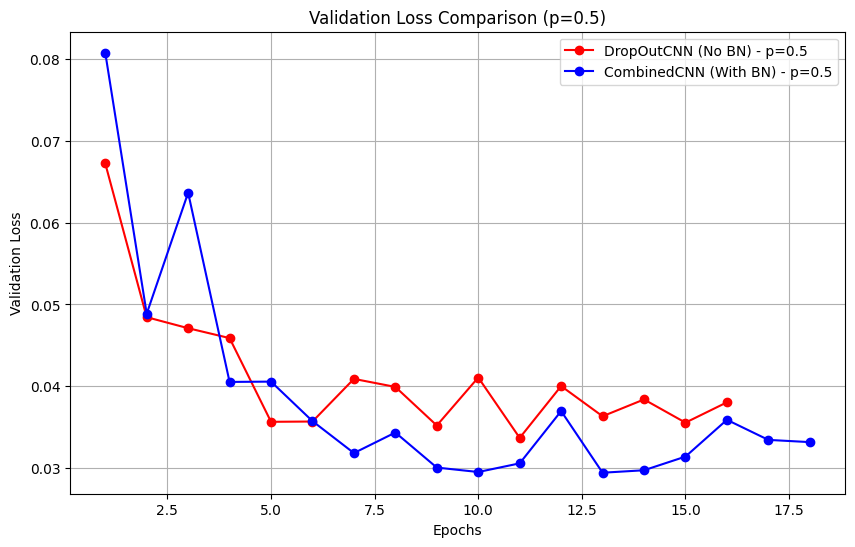

In [61]:
import matplotlib.pyplot as plt

# Get the history lists
dropout_loss = all_results_dropout[0.5]['val_loss']
combined_loss = all_results_combined[0.5]['val_loss']

# Get the epoch counts
epochs_dropout = range(1, len(dropout_loss) + 1)
epochs_combined = range(1, len(combined_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_dropout, dropout_loss, 'r-o', label='DropOutCNN (No BN) - p=0.5')
plt.plot(epochs_combined, combined_loss, 'b-o', label='CombinedCNN (With BN) - p=0.5')
plt.title('Validation Loss Comparison (p=0.5)')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

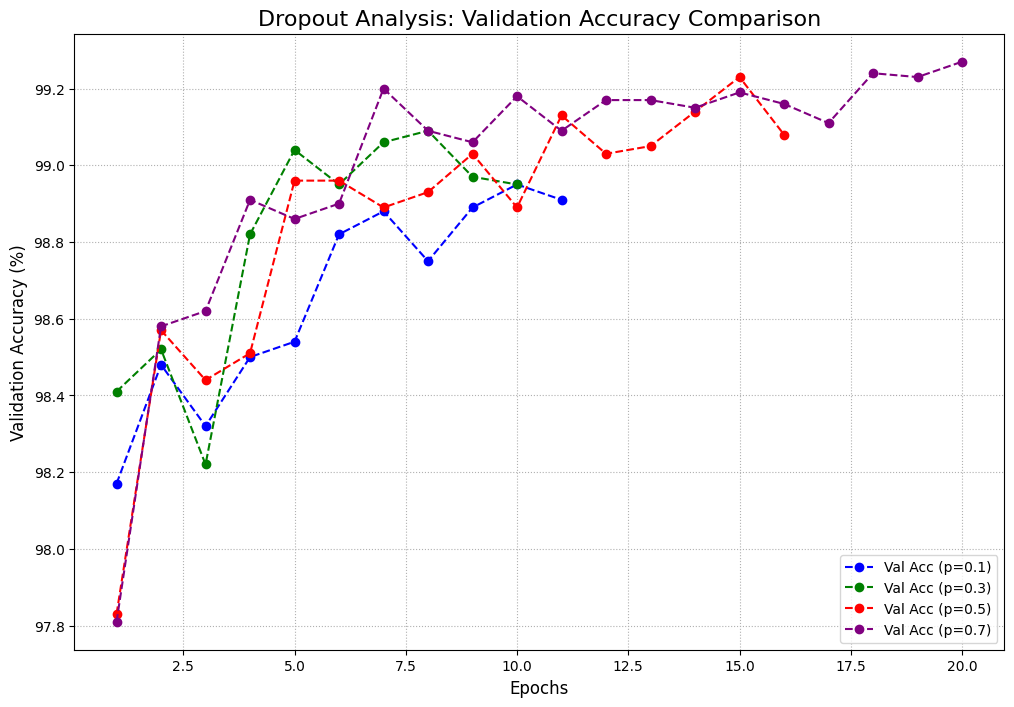

In [62]:
import matplotlib.pyplot as plt

# --- Plot 1: Validation Accuracy for Dropout Analysis ---

plt.figure(figsize=(12, 8))

# Define the rates and colors for plotting
DROPOUT_RATES = [0.1, 0.3, 0.5, 0.7]
colors = ['blue', 'green', 'red', 'purple']

for i, rate in enumerate(DROPOUT_RATES):
    # Get the history for this rate
    if rate in all_results_dropout:
        val_acc_history = all_results_dropout[rate]['val_acc']
        
        # Create an X-axis (epochs) for this specific run
        epochs = range(1, len(val_acc_history) + 1)
        
        # Plot the validation accuracy
        plt.plot(epochs, val_acc_history, color=colors[i], marker='o', linestyle='--',
                 label=f'Val Acc (p={rate})')
    
plt.title('Dropout Analysis: Validation Accuracy Comparison', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle=':')
plt.show()

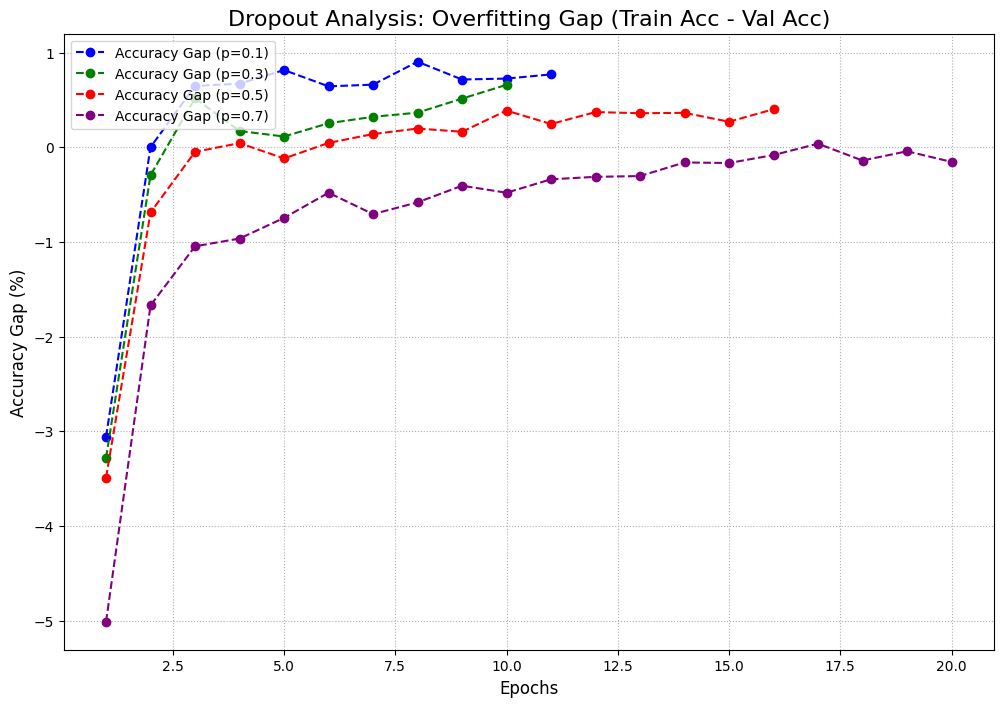

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot 2: Train vs. Val Accuracy GAP (Overfitting) ---

plt.figure(figsize=(12, 8))

DROPOUT_RATES = [0.1, 0.3, 0.5, 0.7]
colors = ['blue', 'green', 'red', 'purple']

for i, rate in enumerate(DROPOUT_RATES):
    if rate in all_results_dropout:
        # Get the history lists
        train_acc = np.array(all_results_dropout[rate]['train_acc'])
        val_acc = np.array(all_results_dropout[rate]['val_acc'])
        
        # Ensure lists are the same length (in case early stopping was different)
        min_epochs = min(len(train_acc), len(val_acc))
        
        # Calculate the GAP
        acc_gap = train_acc[:min_epochs] - val_acc[:min_epochs]
        
        # Create an X-axis
        epochs = range(1, min_epochs + 1)
        
        # Plot the gap
        plt.plot(epochs, acc_gap, color=colors[i], marker='o', linestyle='--',
                 label=f'Accuracy Gap (p={rate})')

plt.title('Dropout Analysis: Overfitting Gap (Train Acc - Val Acc)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy Gap (%)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle=':')
plt.show()

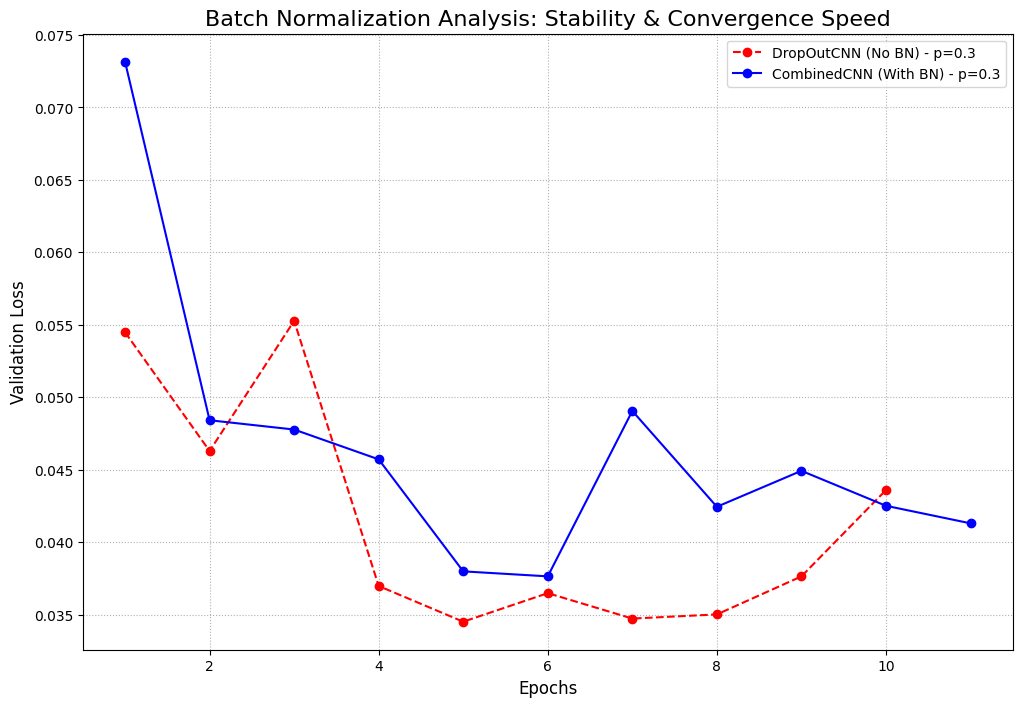

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot: Batch Normalization Stability & Convergence Analysis ---

# Select which dropout rate to use for the comparison
RATE_TO_COMPARE = 0.3

plt.figure(figsize=(12, 8))

# --- 1. Get Data for DropOutCNN (NO Batch Norm) ---
if RATE_TO_COMPARE in all_results_dropout:
    val_loss_no_bn = all_results_dropout[RATE_TO_COMPARE]['val_loss']
    epochs_no_bn = range(1, len(val_loss_no_bn) + 1)
    
    plt.plot(epochs_no_bn, val_loss_no_bn, 
             color='red', marker='o', linestyle='--', 
             label=f'DropOutCNN (No BN) - p={RATE_TO_COMPARE}')

# --- 2. Get Data for CombinedCNN (WITH Batch Norm) ---
if RATE_TO_COMPARE in all_results_combined:
    val_loss_with_bn = all_results_combined[RATE_TO_COMPARE]['val_loss']
    epochs_with_bn = range(1, len(val_loss_with_bn) + 1)
    
    plt.plot(epochs_with_bn, val_loss_with_bn, 
             color='blue', marker='o', linestyle='-', 
             label=f'CombinedCNN (With BN) - p={RATE_TO_COMPARE}')

# --- 3. Format the Plot ---
plt.title('Batch Normalization Analysis: Stability & Convergence Speed', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle=':')

# You might need to set the Y-axis limit to see the difference clearly, as BN converges fast
# plt.ylim(0, 0.2) 

plt.show()